# ShareNet Example Usage

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import csv
        
cwd = os.getcwd()
os.chdir('..')
from utils import *
from sharenet import *
from sharenet_bvs import *
os.chdir(cwd)

## ShareNet: Enhancing PIDC Edge Scores
### Load Regulator & Target Gene Indices

In [2]:
data_dir = './data/'

target_inds = np.loadtxt(os.path.join(data_dir,'target_indices.txt'),dtype=int)
tf_inds = np.loadtxt(os.path.join(data_dir,'tf_indices.txt'),dtype=int)

n_genes = len(set(target_inds.tolist() + tf_inds.tolist()))

### Load PIDC Networks

In [3]:
from scipy.io import mmread

data_dir = './data/'
C = 5 # using 5 cell types

X = []
for celltype_no in range(1,C+1):
    file_name = 'celltype{}.pidc.mtx'.format(celltype_no)
    network = mmread(os.path.join(data_dir,file_name)).toarray()
    X.append(network)

### Load PIDC Network Standard Deviations

In [4]:
from scipy.io import mmread

data_dir = './data/'
C = 5 # using 5 cell types

V = []
for celltype_no in range(1,C+1):
    file_name = 'celltype{}.pidc.std.mtx'.format(celltype_no)
    network = mmread(os.path.join(data_dir,file_name)).toarray()
    V.append(network)

### Running ShareNet

In [5]:
import sharenet

# number of mixture components to use
n_components = 10 

# initialize ShareNet model
model = sharenet.ShareNet(n_components = n_components)

In [6]:
# update model parameters using CAVI
model.fit(X,V,tol=0.01)

0 0.4515296319220179
1 0.5233392123383958
2 0.16262972724244285
3 0.08593736122410743
4 0.05470676538721032
5 0.037300880906527646
6 0.026949222405003415
7 0.0199246491299398
8 0.014911412860484157
9 0.011275878830143872
Time: 49.428 seconds


### Retrieving Revised Edge Scores

In [7]:
revised_X = model.get_revised_edge_scores()

### Evaluating Accuracy: AUPRC (using STRING functional network as reference)

In [8]:
original_networks = {}
for i,celltype_no in enumerate(range(1,C+1)):
    original_networks[celltype_no] = X[i]

revised_networks = {}
for i,celltype_no in enumerate(range(1,C+1)):
    revised_networks[celltype_no] = revised_X[i]

In [9]:
data_dir = './data/'
edge_inds = np.loadtxt(os.path.join(data_dir,'STRING.txt'),delimiter='\t',dtype=int)

ref_network = np.zeros((n_genes,n_genes))
ref_network[(edge_inds[:,0],edge_inds[:,1])] = 1
ref_network += ref_network.T # symmetrize for STRING PPI interactions
ref_network = ref_network.astype(bool).astype(int)
ref_network = ref_network[target_inds][:,tf_inds]

In [10]:
from sklearn.metrics import average_precision_score

data_dict = {'celltype_no': [], 'auprc': []}

for celltype_no in range(1,C+1):

    y_pred = abs(original_networks[celltype_no].flatten())
    y_true = ref_network.flatten()

    auprc = average_precision_score(y_true,y_pred)

    data_dict['celltype_no'].append(celltype_no)
    data_dict['auprc'].append(auprc)

original_df = pd.DataFrame(data_dict)

In [11]:
from sklearn.metrics import average_precision_score

data_dict = {'celltype_no': [], 'auprc': []}

for celltype_no in range(1,C+1):

    y_pred = abs(revised_networks[celltype_no].flatten())
    y_true = ref_network.flatten()

    auprc = average_precision_score(y_true,y_pred)

    data_dict['celltype_no'].append(celltype_no)
    data_dict['auprc'].append(auprc)

revised_df = pd.DataFrame(data_dict)

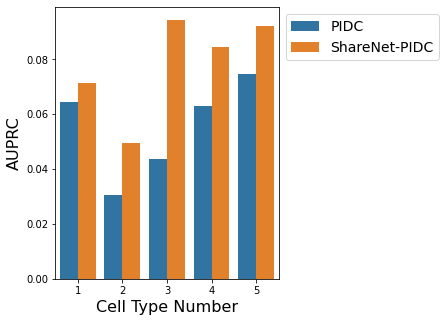

In [12]:
original_df['method'] = 'PIDC'
revised_df['method'] = 'ShareNet-PIDC'

plt.figure(figsize=(4,5))
df = pd.concat([original_df,revised_df])
sns.barplot(x='celltype_no',y='auprc',hue='method',data=df)
plt.legend(bbox_to_anchor=(1,1),fontsize=14)
plt.xlabel('Cell Type Number',fontsize=16)
plt.ylabel('AUPRC',fontsize=16)
plt.show()

## ShareNet: Bayesian Variable Selection Generative Model
### Set Up Regulator-Target Pairing Dictionary

In [22]:
data_dir = './data/'

target_inds = np.loadtxt(os.path.join(data_dir,'target_indices.txt'),dtype=int)

# only consider first 50 target genes (smaller example)
target_inds = target_inds[0:50]


tf_inds = np.loadtxt(os.path.join(data_dir,'tf_indices.txt'),dtype=int)

n_genes = len(set(target_inds.tolist() + tf_inds.tolist()))

regtarget_dict = {target_ind: tf_inds for target_ind in target_inds}

In [23]:
data_dir = './data/'

celltype_data_dict = {}
for celltype_no in range(1,C+1):
    file_name = '{}.mtx'.format(celltype_no)
    celltype_data_dict[celltype_no] = mmread(os.path.join(data_dir,file_name)).toarray()

In [24]:
model = ShareNetGeneModel(celltype_data_dict,use_sharenet=True,regtarget_dict=regtarget_dict,\
                         verbose=True)

In [25]:
model.fit(n_processes=16)

GENE 1 CONVERGED (153 regulators): 200 iterations
GENE 0 CONVERGED (153 regulators): 200 iterations
GENE 2 CONVERGED (153 regulators): 200 iterations
GENE 3 CONVERGED (153 regulators): 200 iterations
GENE 7 CONVERGED (153 regulators): 200 iterationsGENE 6 CONVERGED (153 regulators): 200 iterations

GENE 8 CONVERGED (153 regulators): 200 iterations
GENE 4 CONVERGED (153 regulators): 200 iterations
GENE 5 CONVERGED (153 regulators): 200 iterations
GENE 11 CONVERGED (153 regulators): 200 iterations
GENE 9 CONVERGED (153 regulators): 200 iterations
GENE 12 CONVERGED (153 regulators): 200 iterations
GENE 10 CONVERGED (153 regulators): 200 iterations
GENE 15 CONVERGED (153 regulators): 200 iterations
GENE 14 CONVERGED (153 regulators): 200 iterations
GENE 13 CONVERGED (153 regulators): 200 iterations
GENE 18 CONVERGED (153 regulators): 200 iterations
GENE 16 CONVERGED (153 regulators): 200 iterations
GENE 21 CONVERGED (153 regulators): 200 iterations
GENE 19 CONVERGED (153 regulators): 200 i

### Retrieve Learned Variational Parameters

In [26]:
celltype_no = 1
target_ind = target_inds[0]

model.get_model_params('alpha',celltype_no,target_ind)

array([5.82071308e-03, 9.78742710e-03, 7.53675755e-03, 5.75370019e-03,
       7.62821383e-03, 3.97458933e-03, 1.45617893e-03, 7.47084918e-03,
       1.73451973e-02, 7.61567895e-03, 5.83256932e-04, 2.39306579e-03,
       2.90667506e-03, 3.08470120e-03, 6.90377298e-03, 4.28115485e-03,
       8.36001595e-03, 4.14182010e-03, 3.84595949e-03, 5.04988558e-03,
       7.34279076e-03, 1.88901798e-02, 8.86918242e-03, 4.03467466e-03,
       8.46055976e-03, 2.41245812e-03, 6.09148756e-03, 8.86701258e-03,
       5.74564473e-03, 3.84420542e-03, 1.01263575e-02, 1.97550004e-02,
       1.06970357e-02, 3.52873942e-02, 2.98932018e-03, 1.47001542e-02,
       1.41691146e-03, 1.96272453e-03, 8.70380307e-03, 1.70188658e-02,
       4.37569163e-03, 3.30204238e-03, 4.62815350e-03, 6.42921282e-03,
       2.11819191e-03, 2.04888611e-03, 5.21239446e-04, 2.60057619e-03,
       8.90209318e-04, 3.26532164e-03, 5.34284011e-03, 1.54780977e-03,
       1.68351528e-03, 2.60515781e-03, 2.50586326e-03, 3.67670482e-03,
      

In [27]:
celltype_no = 1
target_ind = target_inds[0]

model.get_model_params('mu',celltype_no,target_ind)

array([-0.00409026,  0.086911  , -0.07234921,  0.05800043, -0.07216249,
        0.02927314,  0.00599972, -0.02237189,  0.1876135 , -0.07203979,
        0.002709  ,  0.02748635,  0.02731317, -0.00338601,  0.01679741,
       -0.03559959,  0.07972121,  0.04774695,  0.04229171, -0.05564634,
       -0.06536474,  0.19832564,  0.06406087,  0.01698714, -0.04847487,
        0.00997865,  0.06385688, -0.09971807,  0.03637801,  0.0443823 ,
       -0.10051408,  0.17806551,  0.02262753,  0.23448179, -0.02111034,
       -0.1714977 , -0.01187897,  0.01784941,  0.03533067,  0.14649504,
        0.05052603,  0.01048001,  0.04254953, -0.02673388, -0.00385538,
        0.00196756,  0.00176392, -0.01254203,  0.00582196, -0.02211406,
        0.04625476,  0.00397816,  0.00241635,  0.02636967,  0.01601299,
        0.03232129, -0.00720372,  0.03590444, -0.02060198,  0.03189016,
       -0.02093297,  0.01156453, -0.00918666,  0.00305383, -0.04177244,
        0.00415847, -0.07351349,  0.09144378,  0.04003444,  0.03